# Lab 7: Applications and Extensions of RNNs

##### A. Please provide the following specifics of your RNN model

__1. RNN architecture type (e.g. Vanilla, LSTM, GRU)__<br />
I used LSTM architecture. <br /><br />
__2. RNN Input dimension and hidden layer dimension__<br />
Input dimension = 1, Hidden layer dimension = 32 <br /><br />
__3. Type of nonlinearity__  <br />
Tanh<br /><br />
__4. Other Network Layers (FC, dropout, etc.)__ <br />
I used FC as output layer. I also used batchnorm layer before FC output layer. <br /><br />
__5. Additional RNN modifications (e.g. DeepRNN, Bi-directional RNN)__ <br />
I used DeepRNN with num_layers = 2<br /><br />
__6. Training Epochs__ <br />
80 <br /><br />
__7. Learning Rate__ <br />
 0.0001 <br /><br />


##### B. Plot the ground truth vs RNN predicted for the last 100 days of the Tesla stock dataset
 Done in Tesla Section

##### Plot the ground truth vs RNN predicted for the last 100 days of the Google stock dataset
 Done in Google Section

##### D. Plot the ground truth vs RNN predicted for the last 100 days of the Dow Jones Industrial Average Index dataset
Done in DJI Section


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid", {'axes.grid' : False})


## Preprocess Data

#### Included with this lab are TSLA.csv, GOOGL.csv and DJI.csv files. Use Pandas to retrieve the dataset. 
#### Use only Open price as your input. (You will train three models for three different stocks, don't mix these data together!)

## Tesla Model

In [2]:
tesla_stocks = pd.read_csv('TSLA.csv')

In [3]:
tesla_stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [4]:
data_points = 2000
data_to_use_tesla = tesla_stocks['Open'].values[-data_points:]

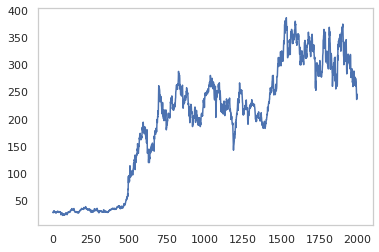

In [5]:
plt.plot(data_to_use_tesla)


### Normalize your data.

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
data_to_use_tesla_norm = scaler.fit_transform(data_to_use_tesla.reshape(-1, 1))
data_to_use_tesla_norm.shape

(2000, 1)

### Split training, validation and testing data

In [7]:
from sklearn.model_selection import train_test_split
def split_data(stock_data, window):
    # create all possible sequences of length seq_len
    data = []
    for index in range(len(stock_data) - window):
        data.append(stock_data[index: index + window])
    data = np.array(data)
    test_set_size = 100
    train_set_size = data.shape[0] - (test_set_size)
    x_train_val = data[:train_set_size,:-1,:]
    y_train_val = data[:train_set_size,-1,:]
    x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.10, random_state=42)
    y_train = y_train.reshape((-1, 1, 1))
    y_val = y_val.reshape((-1, 1, 1))

    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

x_train, y_train, x_val, y_val, x_test, y_test = split_data(data_to_use_tesla_norm, 60)



In [8]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((1656, 59, 1),
 (1656, 1, 1),
 (184, 59, 1),
 (184, 1, 1),
 (100, 59, 1),
 (100, 1))

In [9]:
from torch.utils.data import Dataset, DataLoader
class StockDataset(Dataset):
    
    def __init__(self, X_dataset, Y_dataset):
        
        self.X_dataset = torch.from_numpy(X_dataset).float()
        self.Y_dataset = torch.from_numpy(Y_dataset).float()
        
    def __len__(self):
        return np.shape(self.Y_dataset)[0]

    def __getitem__(self, idx):
        
        return (self.X_dataset[idx, :, :], self.Y_dataset[idx, :, :])
train_batch_size = 60
val_batch_size = 100
train_dataloader_tesla = DataLoader(StockDataset(x_train, y_train), batch_size=train_batch_size, shuffle=True)
val_dataloader_tesla = DataLoader(StockDataset(x_val, y_val), batch_size=val_batch_size, shuffle=True)

### RNN Model

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class LSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.bn = torch.nn.BatchNorm1d(hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().float().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().float().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # print("Tensor:", out[:, -1, :].shape)
        
        # out = self.fc(out[:, -1, :]).reshape(-1, 1, 1)
        out = self.bn(out[:, -1, :])
        out = self.fc(out).reshape(-1, 1, 1)
        return out

### Training code

In [11]:
d = next(iter(train_dataloader_tesla))

In [12]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 80

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(num_epochs):
    loss_all = []
    train_sample_counts = 0
    train_loss = 0.0

    for x_d_train, y_d_train in  train_dataloader_tesla:
        model.train()
        x_d_train, y_d_train = x_d_train.to(device), y_d_train.to(device)
        y_d_train_pred = model(x_d_train)

        loss = criterion(y_d_train_pred, y_d_train)
        optimizer.zero_grad() # reset the gradients 
        loss.backward() # compute backpropagation
        optimizer.step() # perform parameter update
        train_sample_counts += x_d_train.size(0)
        train_loss = loss.item() * train_sample_counts
        loss_all.append(train_loss)

    model.eval()
    val_loss_all = []
    val_sample_counts = 0
    val_loss = 0.0
    with torch.no_grad():
        for x_d_val, y_d_val  in  train_dataloader_tesla:
            x_d_val, y_d_val = x_d_val.to(device), y_d_val.to(device)
            y_d_val_pred = model(x_d_val)

            loss = criterion(y_d_val_pred, y_d_val)
            val_sample_counts += x_d_val.size(0)
            val_loss = loss.item() * val_sample_counts
            val_loss_all.append(val_loss)



    
    print()
    print(f'Epoch: {epoch} \tTraining Loss: {sum(loss_all)/train_sample_counts:.6f}') #  \tTraining Accuracy:  {epoch_accuracy:.6f}')
    print(f'Epoch: {epoch} \tValidation Loss: {sum(val_loss_all)/val_sample_counts:.6f}')


        




Epoch: 0 	Training Loss: 1.130558
Epoch: 0 	Validation Loss: 4.707511

Epoch: 1 	Training Loss: 0.207988
Epoch: 1 	Validation Loss: 3.438247

Epoch: 2 	Training Loss: 0.153781
Epoch: 2 	Validation Loss: 0.833046

Epoch: 3 	Training Loss: 0.154413
Epoch: 3 	Validation Loss: 0.055595

Epoch: 4 	Training Loss: 0.187707
Epoch: 4 	Validation Loss: 0.057190

Epoch: 5 	Training Loss: 0.136503
Epoch: 5 	Validation Loss: 0.053372

Epoch: 6 	Training Loss: 0.157337
Epoch: 6 	Validation Loss: 0.055892

Epoch: 7 	Training Loss: 0.145293
Epoch: 7 	Validation Loss: 0.048232

Epoch: 8 	Training Loss: 0.126949
Epoch: 8 	Validation Loss: 0.044844

Epoch: 9 	Training Loss: 0.112917
Epoch: 9 	Validation Loss: 0.043381

Epoch: 10 	Training Loss: 0.123354
Epoch: 10 	Validation Loss: 0.098819

Epoch: 11 	Training Loss: 0.132336
Epoch: 11 	Validation Loss: 0.040598

Epoch: 12 	Training Loss: 0.133507
Epoch: 12 	Validation Loss: 0.044454

Epoch: 13 	Training Loss: 0.126905
Epoch: 13 	Validation Loss: 0.04511

### Testing code

Text(0.5, 1.0, 'Tesla Stock')

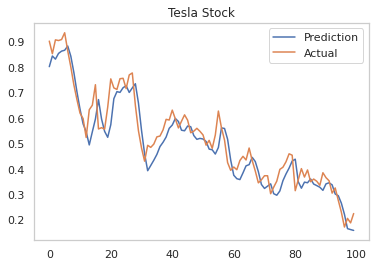

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid", {'axes.grid' : False})


plt.plot(list(range(x_test.shape[0])) , model(torch.from_numpy(x_test).float().to(device)).reshape(-1).detach().cpu().numpy(), label = "Prediction")

plt.plot(y_test, label = "Actual")
plt.legend()
plt.title("Tesla Stock")


## Google Stock

In [14]:
google_stocks = pd.read_csv('GOOGL.csv')

In [15]:
google_stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000
1,2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300
2,2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100
3,2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600


In [16]:
data_points = 2000
data_to_use_google = google_stocks['Open'].values[-data_points:]

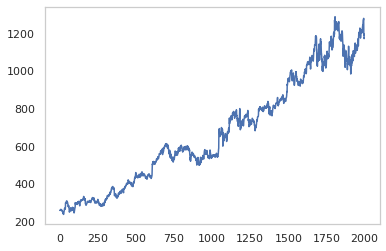

In [17]:
plt.plot(data_to_use_google)


### Normalize your data

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
data_to_use_norm = scaler.fit_transform(data_to_use_google.reshape(-1, 1))
data_to_use_norm.shape

(2000, 1)

### Split training, validation and testing data

In [19]:
from sklearn.model_selection import train_test_split
def split_data(stock_data, window):
    # create all possible sequences of length seq_len
    data = []
    for index in range(len(stock_data) - window):
        data.append(stock_data[index: index + window])
    data = np.array(data)
    test_set_size = 100
    train_set_size = data.shape[0] - (test_set_size)
    x_train_val = data[:train_set_size,:-1,:]
    y_train_val = data[:train_set_size,-1,:]
    x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.10, random_state=42)
    y_train = y_train.reshape((-1, 1, 1))
    y_val = y_val.reshape((-1, 1, 1))

    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

x_train, y_train, x_val, y_val, x_test, y_test = split_data(data_to_use_norm, 60)



In [20]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((1656, 59, 1),
 (1656, 1, 1),
 (184, 59, 1),
 (184, 1, 1),
 (100, 59, 1),
 (100, 1))

In [21]:
from torch.utils.data import Dataset, DataLoader
class StockDataset(Dataset):
    
    def __init__(self, X_dataset, Y_dataset):
        
        self.X_dataset = torch.from_numpy(X_dataset).float()
        self.Y_dataset = torch.from_numpy(Y_dataset).float()
        
    def __len__(self):
        return np.shape(self.Y_dataset)[0]

    def __getitem__(self, idx):
        
        return (self.X_dataset[idx, :, :], self.Y_dataset[idx, :, :])
train_batch_size = 60
val_batch_size = 100
train_dataloader = DataLoader(StockDataset(x_train, y_train), batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(StockDataset(x_val, y_val), batch_size=val_batch_size, shuffle=True)

### RNN Model

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class LSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.bn = torch.nn.BatchNorm1d(hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().float().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().float().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # print("Tensor:", out[:, -1, :].shape)
        
        # out = self.fc(out[:, -1, :]).reshape(-1, 1, 1)
        out = self.bn(out[:, -1, :])
        out = self.fc(out).reshape(-1, 1, 1)
        return out

In [23]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 80

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(num_epochs):
    loss_all = []
    train_sample_counts = 0
    train_loss = 0.0

    for x_d_train, y_d_train in  train_dataloader:
        model.train()
        x_d_train, y_d_train = x_d_train.to(device), y_d_train.to(device)
        y_d_train_pred = model(x_d_train)

        loss = criterion(y_d_train_pred, y_d_train)
        optimizer.zero_grad() # reset the gradients 
        loss.backward() # compute backpropagation
        optimizer.step() # perform parameter update
        train_sample_counts += x_d_train.size(0)
        train_loss = loss.item() * train_sample_counts
        loss_all.append(train_loss)

    model.eval()
    val_loss_all = []
    val_sample_counts = 0
    val_loss = 0.0
    with torch.no_grad():
        for x_d_val, y_d_val  in  train_dataloader:
            x_d_val, y_d_val = x_d_val.to(device), y_d_val.to(device)
            y_d_val_pred = model(x_d_val)

            loss = criterion(y_d_val_pred, y_d_val)
            val_sample_counts += x_d_val.size(0)
            val_loss = loss.item() * val_sample_counts
            val_loss_all.append(val_loss)



    
    print()
    print(f'Epoch: {epoch} \tTraining Loss: {sum(loss_all)/train_sample_counts:.6f}') #  \tTraining Accuracy:  {epoch_accuracy:.6f}')
    print(f'Epoch: {epoch} \tValidation Loss: {sum(val_loss_all)/val_sample_counts:.6f}')


        




Epoch: 0 	Training Loss: 1.048916
Epoch: 0 	Validation Loss: 3.821257

Epoch: 1 	Training Loss: 0.302099
Epoch: 1 	Validation Loss: 2.708952

Epoch: 2 	Training Loss: 0.269267
Epoch: 2 	Validation Loss: 0.766046

Epoch: 3 	Training Loss: 0.219330
Epoch: 3 	Validation Loss: 0.198617

Epoch: 4 	Training Loss: 0.204682
Epoch: 4 	Validation Loss: 0.309012

Epoch: 5 	Training Loss: 0.182535
Epoch: 5 	Validation Loss: 0.166213

Epoch: 6 	Training Loss: 0.184025
Epoch: 6 	Validation Loss: 0.195088

Epoch: 7 	Training Loss: 0.151001
Epoch: 7 	Validation Loss: 0.052130

Epoch: 8 	Training Loss: 0.114994
Epoch: 8 	Validation Loss: 0.060908

Epoch: 9 	Training Loss: 0.125241
Epoch: 9 	Validation Loss: 0.039450

Epoch: 10 	Training Loss: 0.091957
Epoch: 10 	Validation Loss: 0.036907

Epoch: 11 	Training Loss: 0.135080
Epoch: 11 	Validation Loss: 0.043703

Epoch: 12 	Training Loss: 0.108251
Epoch: 12 	Validation Loss: 0.029187

Epoch: 13 	Training Loss: 0.121673
Epoch: 13 	Validation Loss: 0.02148

### Testing code

Text(0.5, 1.0, 'Google Stock')

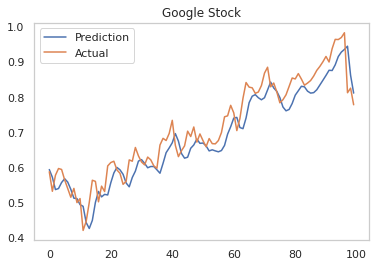

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid", {'axes.grid' : False})


plt.plot(list(range(x_test.shape[0])) , model(torch.from_numpy(x_test).float().to(device)).reshape(-1).detach().cpu().numpy(), label = "Prediction")

plt.plot(y_test, label = "Actual")
plt.legend()
plt.title("Google Stock")


## DJI Stock

In [25]:
dji_stocks = pd.read_csv('DJI.csv')

In [26]:
dji_stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1,1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
2,1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
3,1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
4,1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


In [27]:
data_points = 2000
data_to_use_dji = dji_stocks['Open'].values[-data_points:]

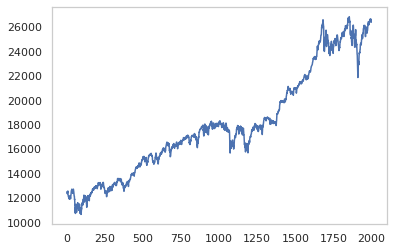

In [28]:
plt.plot(data_to_use_dji)


### Normalize your data

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
data_to_use_norm = scaler.fit_transform(data_to_use_dji.reshape(-1, 1))
data_to_use_norm.shape

(2000, 1)

### Split training, validation and testing data

In [31]:
from sklearn.model_selection import train_test_split
def split_data(stock_data, window):
    # create all possible sequences of length seq_len
    data = []
    for index in range(len(stock_data) - window):
        data.append(stock_data[index: index + window])
    data = np.array(data)
    test_set_size = 100
    train_set_size = data.shape[0] - (test_set_size)
    x_train_val = data[:train_set_size,:-1,:]
    y_train_val = data[:train_set_size,-1,:]
    x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.10, random_state=42)
    y_train = y_train.reshape((-1, 1, 1))
    y_val = y_val.reshape((-1, 1, 1))

    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

x_train, y_train, x_val, y_val, x_test, y_test = split_data(data_to_use_norm, 60)



In [32]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((1656, 59, 1),
 (1656, 1, 1),
 (184, 59, 1),
 (184, 1, 1),
 (100, 59, 1),
 (100, 1))

In [33]:
from torch.utils.data import Dataset, DataLoader
class StockDataset(Dataset):
    
    def __init__(self, X_dataset, Y_dataset):
        
        self.X_dataset = torch.from_numpy(X_dataset).float()
        self.Y_dataset = torch.from_numpy(Y_dataset).float()
        
    def __len__(self):
        return np.shape(self.Y_dataset)[0]

    def __getitem__(self, idx):
        
        return (self.X_dataset[idx, :, :], self.Y_dataset[idx, :, :])
train_batch_size = 60
val_batch_size = 100
train_dataloader = DataLoader(StockDataset(x_train, y_train), batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(StockDataset(x_val, y_val), batch_size=val_batch_size, shuffle=True)

### RNN Model

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class LSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.bn = torch.nn.BatchNorm1d(hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().float().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().float().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # print("Tensor:", out[:, -1, :].shape)
        
        # out = self.fc(out[:, -1, :]).reshape(-1, 1, 1)
        out = self.bn(out[:, -1, :])
        out = self.fc(out).reshape(-1, 1, 1)
        return out

### Split training, validation and testing data

In [35]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 80

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(num_epochs):
    loss_all = []
    train_sample_counts = 0
    train_loss = 0.0

    for x_d_train, y_d_train in  train_dataloader:
        model.train()
        x_d_train, y_d_train = x_d_train.to(device), y_d_train.to(device)
        y_d_train_pred = model(x_d_train)

        loss = criterion(y_d_train_pred, y_d_train)
        optimizer.zero_grad() # reset the gradients 
        loss.backward() # compute backpropagation
        optimizer.step() # perform parameter update
        train_sample_counts += x_d_train.size(0)
        train_loss = loss.item() * train_sample_counts
        loss_all.append(train_loss)

    model.eval()
    val_loss_all = []
    val_sample_counts = 0
    val_loss = 0.0
    with torch.no_grad():
        for x_d_val, y_d_val  in  train_dataloader:
            x_d_val, y_d_val = x_d_val.to(device), y_d_val.to(device)
            y_d_val_pred = model(x_d_val)

            loss = criterion(y_d_val_pred, y_d_val)
            val_sample_counts += x_d_val.size(0)
            val_loss = loss.item() * val_sample_counts
            val_loss_all.append(val_loss)



    
    print()
    print(f'Epoch: {epoch} \tTraining Loss: {sum(loss_all)/train_sample_counts:.6f}') #  \tTraining Accuracy:  {epoch_accuracy:.6f}')
    print(f'Epoch: {epoch} \tValidation Loss: {sum(val_loss_all)/val_sample_counts:.6f}')


        




Epoch: 0 	Training Loss: 3.701858
Epoch: 0 	Validation Loss: 4.764034

Epoch: 1 	Training Loss: 1.169528
Epoch: 1 	Validation Loss: 4.268957

Epoch: 2 	Training Loss: 1.213813
Epoch: 2 	Validation Loss: 3.019636

Epoch: 3 	Training Loss: 1.017269
Epoch: 3 	Validation Loss: 0.942757

Epoch: 4 	Training Loss: 0.957545
Epoch: 4 	Validation Loss: 0.829441

Epoch: 5 	Training Loss: 0.930883
Epoch: 5 	Validation Loss: 0.819251

Epoch: 6 	Training Loss: 0.804665
Epoch: 6 	Validation Loss: 0.719074

Epoch: 7 	Training Loss: 0.816223
Epoch: 7 	Validation Loss: 0.756238

Epoch: 8 	Training Loss: 0.786185
Epoch: 8 	Validation Loss: 0.717088

Epoch: 9 	Training Loss: 0.646873
Epoch: 9 	Validation Loss: 0.543742

Epoch: 10 	Training Loss: 0.584833
Epoch: 10 	Validation Loss: 0.460259

Epoch: 11 	Training Loss: 0.596447
Epoch: 11 	Validation Loss: 0.501662

Epoch: 12 	Training Loss: 0.471044
Epoch: 12 	Validation Loss: 0.448937

Epoch: 13 	Training Loss: 0.460365
Epoch: 13 	Validation Loss: 0.45345

### Testing code

Text(0.5, 1.0, 'DJI Stock')

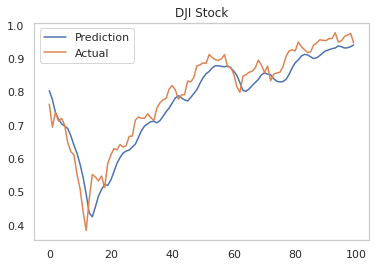

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid", {'axes.grid' : False})


plt.plot(list(range(x_test.shape[0])) , model(torch.from_numpy(x_test).float().to(device)).reshape(-1).detach().cpu().numpy(), label = "Prediction")

plt.plot(y_test, label = "Actual")
plt.legend()
plt.title("DJI Stock")
